In [1]:
# couple issues that I've seen. Single images are not enough to allow a classification
# we might need 24 images per day to get a daily average
# other problems might be the time of day? perhaps dark images are not useful?

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import src.tools as tools
# Dependency imports
import tensorflow_probability as tfp
import tensorflow_addons as tfa

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
stations = ['ParkersBrook','BrownsBrook','GrantPoole']
station_name = stations[2]

wd = f'/datadrive/stream_data/training/{station_name}'
bins = ['train', 'val', 'test']
data ={}
for b in bins:
    datatable_name = f'{wd}/{b}_table.csv'
    data[b] = pd.read_csv(datatable_name)

In [4]:
#lets get the y data
train_dataset = tools.create_regression_data_from_dataframe(data['train'])
val_dataset = tools.create_regression_data_from_dataframe(data['val'])
#test_dataset = tools.create_regression_data_from_dataframe(data['test'])

In [7]:
#input_shape = Xtrain[0].shape
input_shape = (480, 640, 3)

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tfd = tfp.distributions
tfb = tfp.bijectors

def build_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)

    conv_1 = tf.keras.layers.Conv2D(16, 3,\
                     activation='relu', padding='same',\
                     input_shape=input_shape)(model_in)
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(32, 3,\
                     activation='relu', padding='same',\
                     input_shape=input_shape)(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tf.keras.layers.Conv2D(64, 3,\
                     activation='relu', padding='same',\
                     input_shape=input_shape)(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    flat_1 = tf.keras.layers.Flatten()(max_3)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(flat_1)
    model_out = tf.keras.layers.Dense(1)(dense_1)
    model = tf.keras.Model(model_in, model_out)
    return model

def NLL(y, distr): 
    return -distr.log_prob(y) 

def normal_sp(params, bias_size=0, hyperparam=0.001): 
    n = params + bias_size
    c = np.log(np.expm1(1.))
    return tfd.Normal(loc=params[...,:1],\
                      scale=1e-5 + tf.math.softplus(hyperparam * params[...,1:]))


# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    out = tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])
    return out

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    out = tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])
    return out

def build_bayes_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)
    #32 convolution filters used each of size 3x3
    conv_1 = tfp.python.layers.Convolution2DFlipout(16, kernel_size=(3, 3),\
                                                    padding="same", \
                                                    activation='relu',\
                                                   input_shape=input_shape)(model_in)
    #convolutional layer with rectified linear unit activation
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    #randomly turn neurons on and off to improve convergence
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                    padding="same",\
                                                    activation='relu')(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3),\
                                                    padding="same",\
                                                    activation='relu')(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    #flatten since too many dimensions, we only want a classification output
    flat_1 = tf.keras.layers.Flatten()(max_3)
    #fully connected to get all relevant data
    #dense_1 = tfp.python.layers.DenseFlipout(128, activation='relu')(flat_1)
    #hidden = Dense(20, activation='relu')(dense_1)
    #params = Dense(2, activation='relu')(hidden)
    #dense_2 = tfp.python.layers.DenseFlipout(1, activation=None)(dense_1)
    #dense_2 = Dense(2, activation='relu')(dense_1)
    dense_2 = tfp.layers.DenseVariational(1+1, posterior_mean_field, \
                               prior_trainable,\
                               kl_weight=1/X_train.shape[0])(flat_1)
    model_out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1],\
                                                                   scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))(dense_2)
    
    #model_out = tfp.layers.DistributionLambda(normal_sp)(dense_2)
    model = tf.keras.Model(model_in, model_out)
    return model

def my_dist(params):
    return tfd.Normal(loc=params, scale=0.0003)

def build_simple_bcnn(input_shape):
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(16, kernel_size=(3, 3),\
                                                    padding="same", \
                                                    activation='relu',\
                                                   input_shape=input_shape)(model_in)
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                padding="same", \
                                                activation='relu',\
                                               input_shape=input_shape)(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3),\
                                                padding="same", \
                                                activation='relu',\
                                               input_shape=input_shape)(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    flat_1 = tf.keras.layers.Flatten()(max_3)
    dense_1 = Dense(128, activation='relu')(flat_1)
    params = Dense(1)(dense_1)
    dist = tfp.layers.DistributionLambda(my_dist)(params)
    model = Model(inputs=model_in, outputs=dist)
    return model
    

In [19]:
epochs = 350
input_shape = (480, 640, 3)
cnn = build_simple_bcnn(input_shape)
optimizer = tf.keras.optimizers.Adam(lr=0.01)
#optimizer = tfa.optimizers.AdamW(lr=0.0075, weigh_decay=0.001)
cnn.compile(loss=NLL,\
            metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)),\
            optimizer=optimizer)
batch_size = 18
history = cnn.fit(train_dataset.shuffle(20).padded_batch(batch_size),\
                    validation_data=val_dataset.batch(batch_size),\
                    epochs=epochs)

Epoch 1/350
32/32 [==============================] - 14s 452ms/step - loss: 4500847329280.0000 - r_square: -4407982.0000 - val_loss: 185772656.0000 - val_r_square: -161.6577
Epoch 2/350
32/32 [==============================] - 14s 434ms/step - loss: 7999890.0000 - r_square: -6.7771 - val_loss: 2246634.2500 - val_r_square: -0.9161
Epoch 3/350
32/32 [==============================] - 14s 434ms/step - loss: 2063479.5000 - r_square: -0.9631 - val_loss: 1750152.0000 - val_r_square: -0.4814
Epoch 4/350
32/32 [==============================] - 14s 435ms/step - loss: 1824563.3750 - r_square: -0.7292 - val_loss: 2984893.7500 - val_r_square: -1.5631
Epoch 5/350
32/32 [==============================] - 14s 438ms/step - loss: 4909447.0000 - r_square: -3.7505 - val_loss: 1317879.2500 - val_r_square: -0.1029
Epoch 6/350
32/32 [==============================] - 14s 436ms/step - loss: 1329293.0000 - r_square: -0.2445 - val_loss: 2945204.2500 - val_r_square: -1.5283
Epoch 7/350
32/32 [=================

Epoch 53/350
32/32 [==============================] - 14s 436ms/step - loss: 1088529.1250 - r_square: -0.0101 - val_loss: 1175184.7500 - val_r_square: 0.0209
Epoch 54/350
32/32 [==============================] - 14s 434ms/step - loss: 1072175.3750 - r_square: 0.0059 - val_loss: 1214486.3750 - val_r_square: -0.0137
Epoch 55/350
32/32 [==============================] - 14s 437ms/step - loss: 1082808.0000 - r_square: -0.0046 - val_loss: 1289947.6250 - val_r_square: -0.0799
Epoch 56/350
32/32 [==============================] - 14s 436ms/step - loss: 1050888.8750 - r_square: 0.0266 - val_loss: 1217568.5000 - val_r_square: -0.0164
Epoch 57/350
32/32 [==============================] - 14s 436ms/step - loss: 1078193.5000 - r_square: -7.5579e-05 - val_loss: 1210891.3750 - val_r_square: -0.0107
Epoch 58/350
32/32 [==============================] - 14s 437ms/step - loss: 1060231.6250 - r_square: 0.0174 - val_loss: 1227495.8750 - val_r_square: -0.0250
Epoch 59/350
32/32 [==========================

32/32 [==============================] - 14s 435ms/step - loss: 564339.7500 - r_square: 0.5030 - val_loss: 737849.6250 - val_r_square: 0.4036
Epoch 106/350
32/32 [==============================] - 14s 436ms/step - loss: 640088.1250 - r_square: 0.4288 - val_loss: 920956.5625 - val_r_square: 0.2432
Epoch 107/350
32/32 [==============================] - 14s 434ms/step - loss: 529759.0000 - r_square: 0.5368 - val_loss: 803585.1875 - val_r_square: 0.3459
Epoch 108/350
32/32 [==============================] - 14s 436ms/step - loss: 458632.9375 - r_square: 0.6065 - val_loss: 713748.8125 - val_r_square: 0.4247
Epoch 109/350
32/32 [==============================] - 14s 437ms/step - loss: 436855.7188 - r_square: 0.6278 - val_loss: 798572.0625 - val_r_square: 0.3502
Epoch 110/350
32/32 [==============================] - 14s 436ms/step - loss: 499532.7188 - r_square: 0.5664 - val_loss: 751446.9375 - val_r_square: 0.3916
Epoch 111/350
32/32 [==============================] - 14s 436ms/step - loss: 

32/32 [==============================] - 14s 436ms/step - loss: 908436.0000 - r_square: 0.1658 - val_loss: 1086111.3750 - val_r_square: 0.0985
Epoch 158/350
32/32 [==============================] - 14s 436ms/step - loss: 872676.4375 - r_square: 0.2008 - val_loss: 1001782.6875 - val_r_square: 0.1724
Epoch 159/350
32/32 [==============================] - 14s 436ms/step - loss: 958726.8750 - r_square: 0.1165 - val_loss: 963793.0000 - val_r_square: 0.2055
Epoch 160/350
32/32 [==============================] - 14s 437ms/step - loss: 893803.2500 - r_square: 0.1801 - val_loss: 948623.8750 - val_r_square: 0.2187
Epoch 161/350
32/32 [==============================] - 14s 437ms/step - loss: 836163.0000 - r_square: 0.2366 - val_loss: 926265.8125 - val_r_square: 0.2384
Epoch 162/350
32/32 [==============================] - 14s 437ms/step - loss: 961924.6875 - r_square: 0.1133 - val_loss: 1217818.8750 - val_r_square: -0.0170
Epoch 163/350
32/32 [==============================] - 14s 436ms/step - lo

32/32 [==============================] - 14s 438ms/step - loss: 282021.6250 - r_square: 0.7790 - val_loss: 566654.1250 - val_r_square: 0.5531
Epoch 210/350
32/32 [==============================] - 14s 437ms/step - loss: 265409.5000 - r_square: 0.7953 - val_loss: 722267.7500 - val_r_square: 0.4170
Epoch 211/350
32/32 [==============================] - 14s 437ms/step - loss: 264892.4375 - r_square: 0.7958 - val_loss: 774859.4375 - val_r_square: 0.3707
Epoch 212/350
32/32 [==============================] - 14s 435ms/step - loss: 1020938.8750 - r_square: 0.0553 - val_loss: 1251050.5000 - val_r_square: -0.0463
Epoch 213/350
32/32 [==============================] - 14s 437ms/step - loss: 1070331.0000 - r_square: 0.0070 - val_loss: 1254629.7500 - val_r_square: -0.0495
Epoch 214/350
32/32 [==============================] - 14s 437ms/step - loss: 1020069.8750 - r_square: 0.0563 - val_loss: 1070945.7500 - val_r_square: 0.1114
Epoch 215/350
32/32 [==============================] - 14s 435ms/step 

Epoch 261/350
32/32 [==============================] - 14s 436ms/step - loss: 1076095.5000 - r_square: 0.0011 - val_loss: 1243211.6250 - val_r_square: -0.0398
Epoch 262/350
32/32 [==============================] - 14s 435ms/step - loss: 1078305.3750 - r_square: -9.5701e-04 - val_loss: 1260691.1250 - val_r_square: -0.0550
Epoch 263/350
32/32 [==============================] - 14s 437ms/step - loss: 1078170.1250 - r_square: -9.6762e-04 - val_loss: 1260073.3750 - val_r_square: -0.0545
Epoch 264/350
32/32 [==============================] - 14s 436ms/step - loss: 1080932.5000 - r_square: -0.0036 - val_loss: 1238536.5000 - val_r_square: -0.0357
Epoch 265/350
32/32 [==============================] - 14s 435ms/step - loss: 1076598.0000 - r_square: 6.0576e-04 - val_loss: 1238771.1250 - val_r_square: -0.0358
Epoch 266/350
32/32 [==============================] - 14s 436ms/step - loss: 1083902.1250 - r_square: -0.0066 - val_loss: 1211413.8750 - val_r_square: -0.0119
Epoch 267/350
32/32 [=========

32/32 [==============================] - 14s 436ms/step - loss: 1072813.2500 - r_square: 0.0041 - val_loss: 1256828.6250 - val_r_square: -0.0520
Epoch 313/350
32/32 [==============================] - 14s 436ms/step - loss: 1070479.7500 - r_square: 0.0063 - val_loss: 1313937.1250 - val_r_square: -0.1018
Epoch 314/350
32/32 [==============================] - 14s 435ms/step - loss: 1069040.5000 - r_square: 0.0077 - val_loss: 1240745.3750 - val_r_square: -0.0379
Epoch 315/350
32/32 [==============================] - 14s 435ms/step - loss: 1062426.8750 - r_square: 0.0142 - val_loss: 1306096.7500 - val_r_square: -0.0951
Epoch 316/350
32/32 [==============================] - 14s 436ms/step - loss: 1057984.7500 - r_square: 0.0185 - val_loss: 1248934.6250 - val_r_square: -0.0451
Epoch 317/350
32/32 [==============================] - 14s 436ms/step - loss: 1056430.3750 - r_square: 0.0200 - val_loss: 1257683.7500 - val_r_square: -0.0526
Epoch 318/350
32/32 [==============================] - 14s 4

In [20]:
modelname = 'simple_bcnn_regression'
import os
if not os.path.exists(f'/datadrive/model/{station_name}/{modelname}'):
    subdirs = ['history','weights']
    for sub in subdirs:
        os.makedirs(f'/datadrive/model/{station_name}/{modelname}/{sub}')
pd.DataFrame(history.history).to_csv(f'/datadrive/model/{station_name}/{modelname}/history/{modelname}.csv')
cnn.save(f'/datadrive/model/{station_name}/{modelname}/weights/{modelname}.h5') 
jsonfile = f'/datadrive/model/{station_name}/{modelname}/weights/{modelname}.json'
model_json = cnn.to_json()
with open(jsonfile, "w") as json_file:
    json_file.write(model_json)

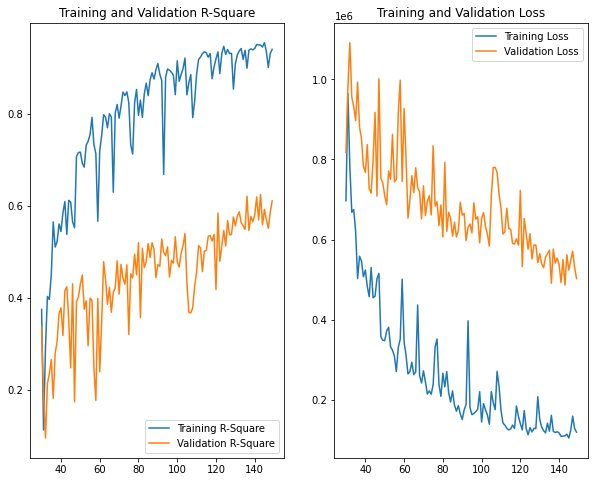

In [16]:
skip = 30
acc = history.history['r_square'][skip:]
val_acc = history.history['val_r_square'][skip:]

loss = history.history['loss'][skip:]
val_loss = history.history['val_loss'][skip:]

epochs_range = range(epochs)[skip:]

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training R-Square')
plt.plot(epochs_range, val_acc, label='Validation R-Square')
plt.legend(loc='lower right')
plt.title('Training and Validation R-Square')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
test = test_dataset.take(1)

NameError: name 'test_dataset' is not defined

In [18]:
for im, label in test:
    print(im, label)

NameError: name 'test' is not defined